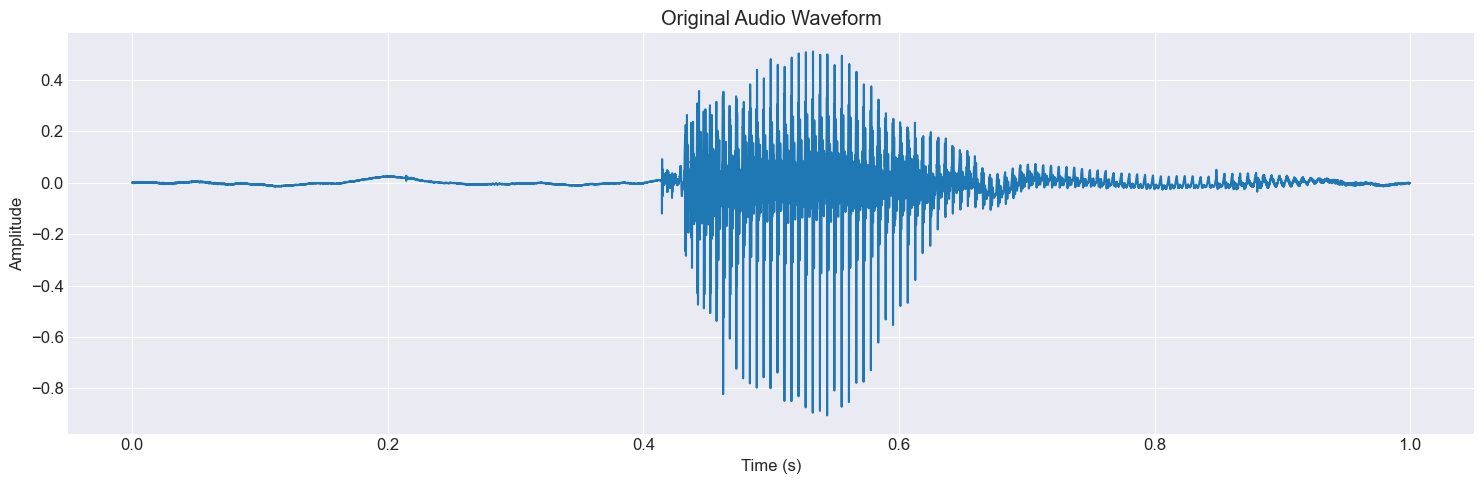

Original audio: 16000 samples, 1.0000 seconds, sample rate: 16000 Hz


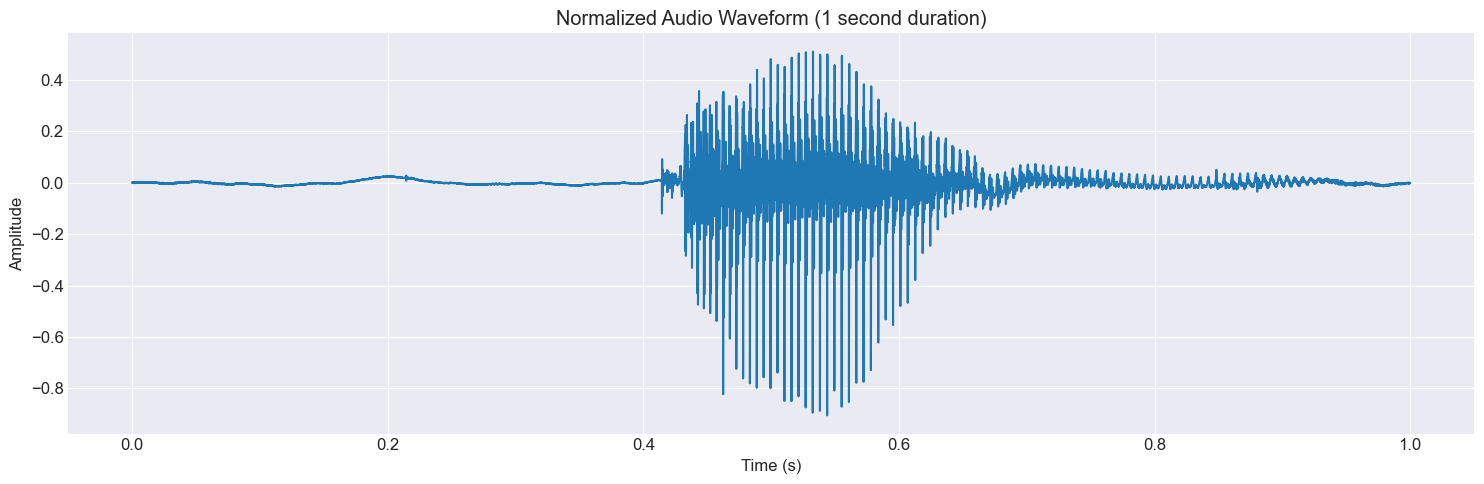

Normalized audio: 16000 samples, 1.0000 seconds


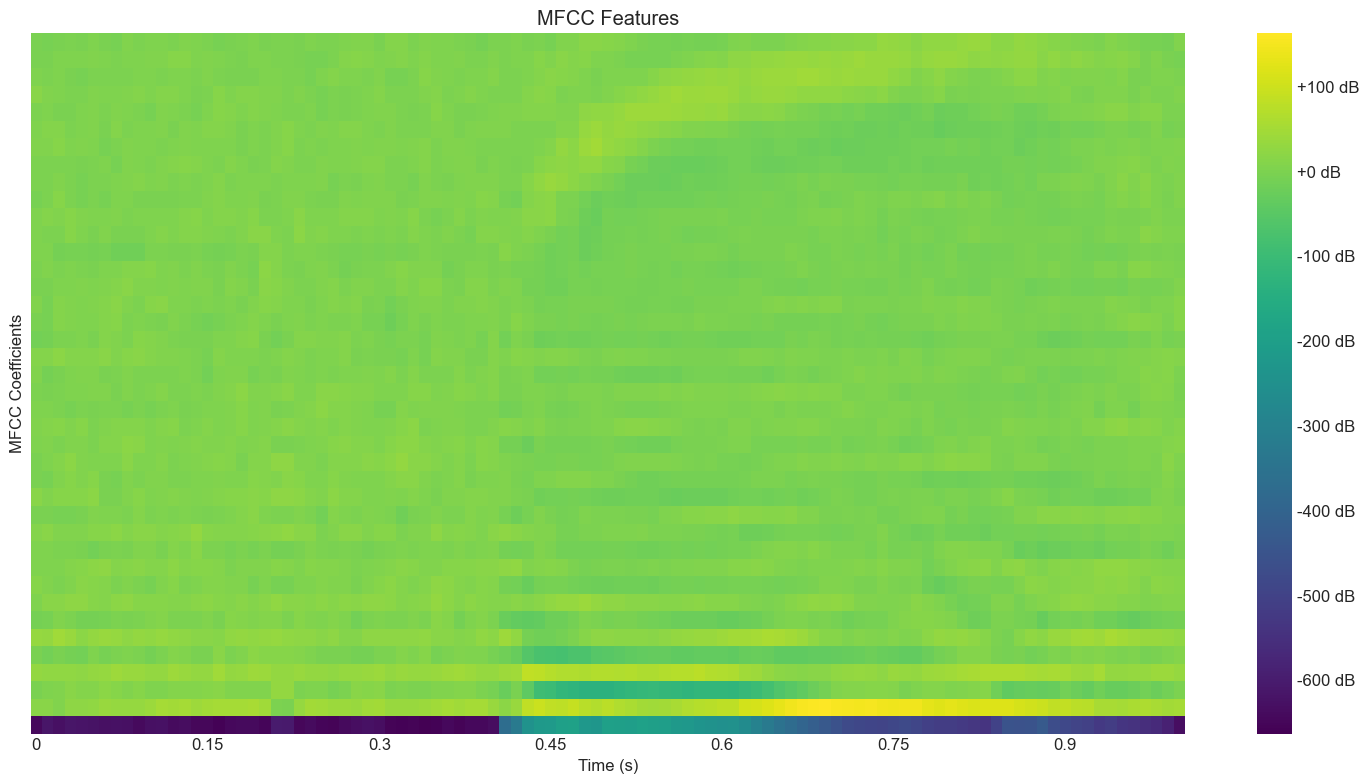

MFCC features shape: (40, 101)
Number of MFCC coefficients: 40
Number of time frames: 101


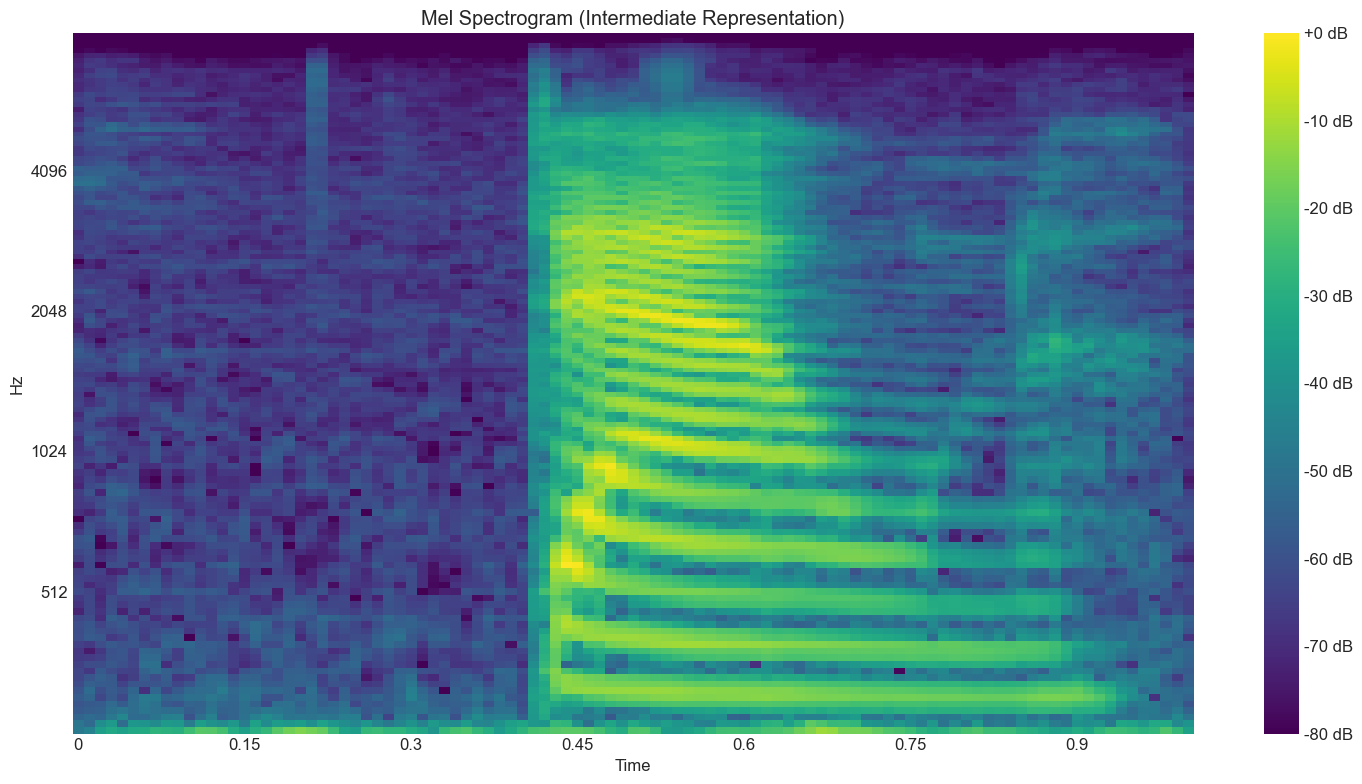


--- Preprocessing Pipeline Explanation ---

1. Audio Loading:
   - The raw audio file is loaded and converted to mono if needed
   - The sampling rate is verified and resampled to 16 kHz if necessary
   - The result is a 1D array representing the waveform

2. Duration Normalization:
   - For files longer than 1 second: Center-crop to keep the highest energy segment
   - For files shorter than 1 second: Zero-pad symmetrically to reach exactly 1 second
   - This ensures all samples have the same temporal dimension

3. MFCC Feature Extraction:
   - Compute the Mel-frequency cepstral coefficients with the following parameters:
     * n_mfcc = 40 (number of coefficients)
     * n_fft = 512 (window size for the FFT)
     * hop_length = 160 (10ms steps at 16kHz)
     * fmin = 20 Hz, fmax = 8000 Hz (frequency range)
   - The result is a 2D array (40 coefficients × time frames)
   - This time-frequency representation captures the perceptually relevant aspects of speech

The MFCC features serve

In [4]:
# Audio Preprocessing for Speech Command Recognition
# This notebook demonstrates the preprocessing steps used in the speech command recognition project

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import librosa
import librosa.display
import os



# Define constants
TARGET_SR = 16000  # Dataset native sample rate
AUDIO_DURATION = 1.0  # in seconds
SAVE_DIR='results/preprocessing'
os.makedirs(SAVE_DIR, exist_ok=True)


# 1. Load Audio Function
def load_audio(path, target_sr=TARGET_SR):
    """Return mono float32 waveform & sr, resampling to target_sr if needed."""
    wav, sr = librosa.load(path, sr=None, mono=True)
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return wav.astype(np.float32), sr

# 2. Audio Duration Normalization
def normalize_audio_duration(audio, sr, duration=AUDIO_DURATION):
    """Centre-crop (or zero-pad) waveform to exactly <duration> seconds."""
    frame_len = int(sr * duration)
    if len(audio) >= frame_len:  # crop - keep loudest 1s
        energy = librosa.util.frame(audio, frame_length=frame_len, hop_length=1)
        start = np.argmax(np.sum(energy**2, axis=0))
        audio = audio[start:start + frame_len]
    else:  # pad
        pad = frame_len - len(audio)
        audio = np.pad(audio, (pad // 2, pad - pad // 2))
    return audio

# 3. MFCC Feature Extraction
def extract_mfcc(audio, sr, n_mfcc=40):
    """Return MFCC array (n_mfcc × frames) as float32."""
    return librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc,
        n_fft=512, hop_length=160, fmin=20, fmax=sr // 2
    ).astype(np.float32)

# Setup figure styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 12})

# Load and preprocess the audio file
file_path = 'data/speech_commands_v0.01/down/0b40aa8e_nohash_0.wav'

# Step 1: Load the audio file
audio, sr = load_audio(file_path)

# Plot 1: Original waveform
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
time = np.arange(0, len(audio)) / sr
plt.plot(time, audio)
plt.title('Original Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/original_waveform.png')
plt.show()

# Print basic audio information
print(f"Original audio: {len(audio)} samples, {len(audio)/sr:.4f} seconds, sample rate: {sr} Hz")

# Step 2: Normalize audio duration
normalized_audio = normalize_audio_duration(audio, sr)

# Plot 2: Normalized waveform
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
time = np.arange(0, len(normalized_audio)) / sr
plt.plot(time, normalized_audio)
plt.title('Normalized Audio Waveform (1 second duration)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/normalized_waveform.png')
plt.show()

# Print normalized audio information
print(f"Normalized audio: {len(normalized_audio)} samples, {len(normalized_audio)/sr:.4f} seconds")

# Step 3: Extract MFCC features
mfcc_features = extract_mfcc(normalized_audio, sr)

# Plot 3: MFCC features
plt.figure(figsize=(15, 8))
plt.subplot(1, 1, 1)
librosa.display.specshow(
    mfcc_features, 
    x_axis='time', 
    sr=sr, 
    hop_length=160,
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC Features')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/mfcc_features.png')
plt.show()

# Print MFCC features information
print(f"MFCC features shape: {mfcc_features.shape}")
print(f"Number of MFCC coefficients: {mfcc_features.shape[0]}")
print(f"Number of time frames: {mfcc_features.shape[1]}")

# Bonus visualization: Mel spectrogram (intermediate step before MFCC)
mel_spec = librosa.feature.melspectrogram(
    y=normalized_audio, 
    sr=sr, 
    n_fft=512, 
    hop_length=160, 
    fmin=20, 
    fmax=sr // 2
)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(15, 8))
plt.subplot(1, 1, 1)
librosa.display.specshow(
    log_mel_spec, 
    x_axis='time', 
    y_axis='mel', 
    sr=sr, 
    hop_length=160,
    fmin=20, 
    fmax=sr // 2,
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Intermediate Representation)')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/mel_spectrogram.png')
plt.show()

# Detailed explanation of preprocessing steps
print("\n--- Preprocessing Pipeline Explanation ---")
print("""
1. Audio Loading:
   - The raw audio file is loaded and converted to mono if needed
   - The sampling rate is verified and resampled to 16 kHz if necessary
   - The result is a 1D array representing the waveform

2. Duration Normalization:
   - For files longer than 1 second: Center-crop to keep the highest energy segment
   - For files shorter than 1 second: Zero-pad symmetrically to reach exactly 1 second
   - This ensures all samples have the same temporal dimension

3. MFCC Feature Extraction:
   - Compute the Mel-frequency cepstral coefficients with the following parameters:
     * n_mfcc = 40 (number of coefficients)
     * n_fft = 512 (window size for the FFT)
     * hop_length = 160 (10ms steps at 16kHz)
     * fmin = 20 Hz, fmax = 8000 Hz (frequency range)
   - The result is a 2D array (40 coefficients × time frames)
   - This time-frequency representation captures the perceptually relevant aspects of speech

The MFCC features serve as the input to the neural network models for speech command recognition.
""")